# **Neuropolis: Building an artificial intelligence system for human brain activity prediction (EEG, fMRI)**

#### Version: 10th March 2024

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through nine Notebooks:

*01: fMRI Preprocessing*

***02: EEG Preprocessing***

*03: Linear Regression*

*04: KNN, Decision Trees, Random Forests, SVM*

*05: Neural Networks*

*06: Convolutional Neural Networks*

*07: Recurrent Neural Networks*

*08: Transformers*

*09: Human Brain Predictability Map*

==============================================================================================

### Notebook 02

# **EEG Preprocessing**

## **1. EEG Data Extraction**

- **Data**: We extract the EEG data preprocessed by the authors of the research work (neuropolis/README.md). From each file, we should be able to extract a 2D NumPy array with dimensions (64, 80200), where the first dimension corresponds to the number of channels, and the second dimension to the number of time points. In this 2D NumPy array, each value corresponds to the voltage signal recorded at a particular electrode, and for a particular time point. 

- **Library**: In order to extract the 2D NumPy arrays from the BrainVision files, we use MNE, a library dedicated to human neurophysiological data: https://mne.tools/stable/index.html. The Info data structures from MNE contain some metadata. A description of the Info data structure can be found here: https://mne.tools/stable/auto_tutorials/intro/30_info.html. 

- **Plots**: Once the EEG data is extracted, we plot some data from the C1 channel, and observe some typical EEG fluctuations. When visualizing such time series, we must remember that we are only looking at one channel, corresponding to a single electrode. 

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import mne
import yasa
import pickle

In [3]:
# Define the raw data path. 
raw_data_path = '../ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis_preprocessed_data/'

In [4]:
# Define the list of subjects. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [5]:
# Define an example subject. 
subject = subjects[0]
subject

'sub-xp101'

In [6]:
# Define the path of the header file (.vhdr) for this subject, for the eegfmriNF condition. 
vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-eegfmriNF_eeg_pp.vhdr'

# Load the EEG data using the MNE library. 
channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)

/var/folders/8y/sg28phf55jv3mkr_l1g50xn40000gn/T/ipykernel_6440/3340906358.py:5: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['ECG']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)


In [7]:
# Display the number of channels. 
len(channels_data.ch_names)

64

In [8]:
# Display the channels names. 
print(channels_data.ch_names)

['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'Oz', 'FC1', 'FC2', 'CP1', 'CP2', 'FC5', 'FC6', 'CP5', 'CP6', 'TP9', 'TP10', 'POz', 'ECG', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'AF3', 'AF4', 'FC3', 'FC4', 'CP3', 'CP4', 'PO3', 'PO4', 'F5', 'F6', 'C5', 'C6', 'P5', 'P6', 'AF7', 'AF8', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'FT9', 'FT10', 'Fpz', 'CPz']


In [9]:
# Identify the C1 channel index. 
c1_channel_index = channels_data.ch_names.index('C1')
c1_channel_index

34

In [10]:
# Display information about the EEG data. 
channels_data.info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T7, T8, P7, ...
 chs: 63 EEG, 1 misc
 custom_ref_applied: False
 dig: 66 items (3 Cardinal, 63 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2015-08-14 15:34:52 UTC
 nchan: 64
 projs: []
 sfreq: 200.0 Hz
>

In [11]:
# Retrieve the sampling frequency. 
sampling_frequency = channels_data.info['sfreq']
sampling_frequency

200.0

In [12]:
# Display the time points. 
channels_data.times

array([0.00000e+00, 5.00000e-03, 1.00000e-02, ..., 4.00985e+02,
       4.00990e+02, 4.00995e+02])

In [13]:
# Display the number of time points. 
channels_data.times.shape[0]

80200

In [14]:
# Compute the total length in seconds. 
channels_data.times.shape[0] / sampling_frequency

401.0

In [15]:
# Check that the data is in float64 format. 
channels_data.times.dtype == np.dtype(np.float64)

True

In [16]:
# Compute the number of unique time differences between two consecutive onsets, rounding up to the 10th decimal. 
time_differences = np.unique(np.unique(channels_data.times[1:] - channels_data.times[:-1]).round(10))
time_differences

array([0.005])

In [17]:
# Extract the EEG data as a NumPy array. 
np_channels_data = channels_data.get_data()
np_channels_data

array([[-2.24100006e-04, -2.30300003e-04, -2.32900009e-04, ...,
        -7.44299988e-04, -7.41400024e-04, -7.40400024e-04],
       [-1.18000000e-04, -1.21500000e-04, -1.25300003e-04, ...,
        -5.90900024e-04, -5.84500000e-04, -5.82299988e-04],
       [-1.05300003e-04, -1.10800003e-04, -1.11200005e-04, ...,
        -1.06700005e-04, -1.05400002e-04, -1.03599998e-04],
       ...,
       [-2.31000004e-05, -2.07000008e-05, -2.35000000e-05, ...,
        -1.27900002e-04, -1.31800003e-04, -1.35500000e-04],
       [-4.67000008e-05, -4.81000023e-05, -4.92999992e-05, ...,
        -6.09000015e-05, -6.26000023e-05, -6.50999985e-05],
       [-2.46000004e-05, -2.73000011e-05, -3.03000011e-05, ...,
        -1.97000008e-05, -1.87000008e-05, -1.72000008e-05]])

In [18]:
# Check that this is indeed a NumPy array. 
type(np_channels_data)

numpy.ndarray

In [19]:
# Display the size of the array. 
np_channels_data.shape

(64, 80200)

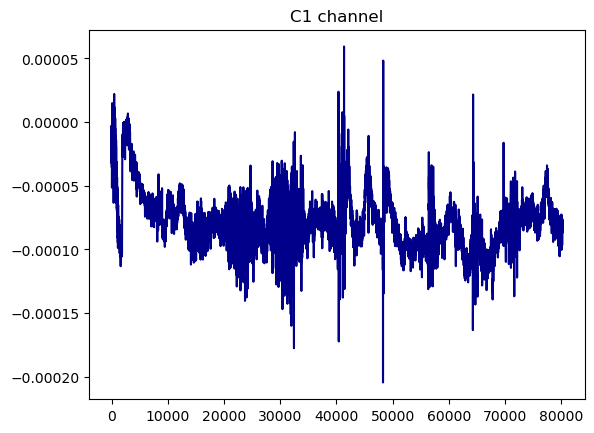

In [20]:
# Plot the data for the C1 channel. 
plt.plot(np_channels_data[c1_channel_index, :], c = 'darkblue')
plt.title('C1 channel');

In [21]:
# Define an arbitrary time interval, and compute the time points for this interval. 
time_interval = [10, 12]
starting_point, ending_point = int(sampling_frequency * time_interval[0]), int(sampling_frequency * time_interval[1])
print(str(ending_point - starting_point) + ' time points')

400 time points


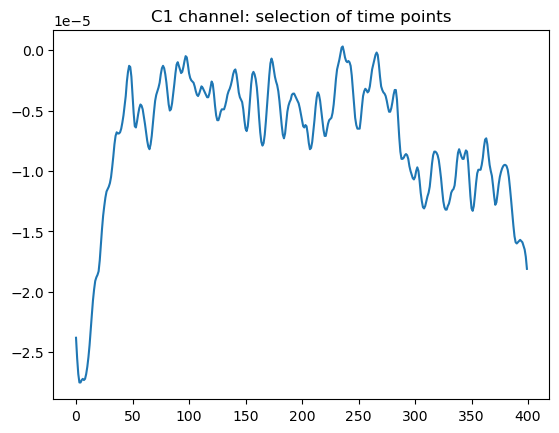

In [22]:
# Plot the data for the C1 channel, focusing on a selection of time points. 
plt.plot(np_channels_data[c1_channel_index, starting_point:ending_point])
plt.title('C1 channel: selection of time points');

## **2. Exploratory Data Analysis (EDA)**

- **Plots**: We explore the EEG data at our disposal by comparing the different channels. 

- **Frequencies**: We compute the Power Spectral Density (PSD) for a selection of time points, for frequencies between 1 and 40 Hz, using both the Welch method and the multitaper method. Then, we compute the bandpowers for a series of frequency bands of interest: delta (1-4 Hz), theta (4-8 Hz), alpha (8-12 Hz), sigma (12-16 Hz), beta (16-30 Hz), gamma (30-40 Hz). These frequency bands are widely used in EEG research works, even if their precise definition can vary. 

- **Observations**: At this level of analysis, our EEG data shows some spikes that may need outlier removal. 

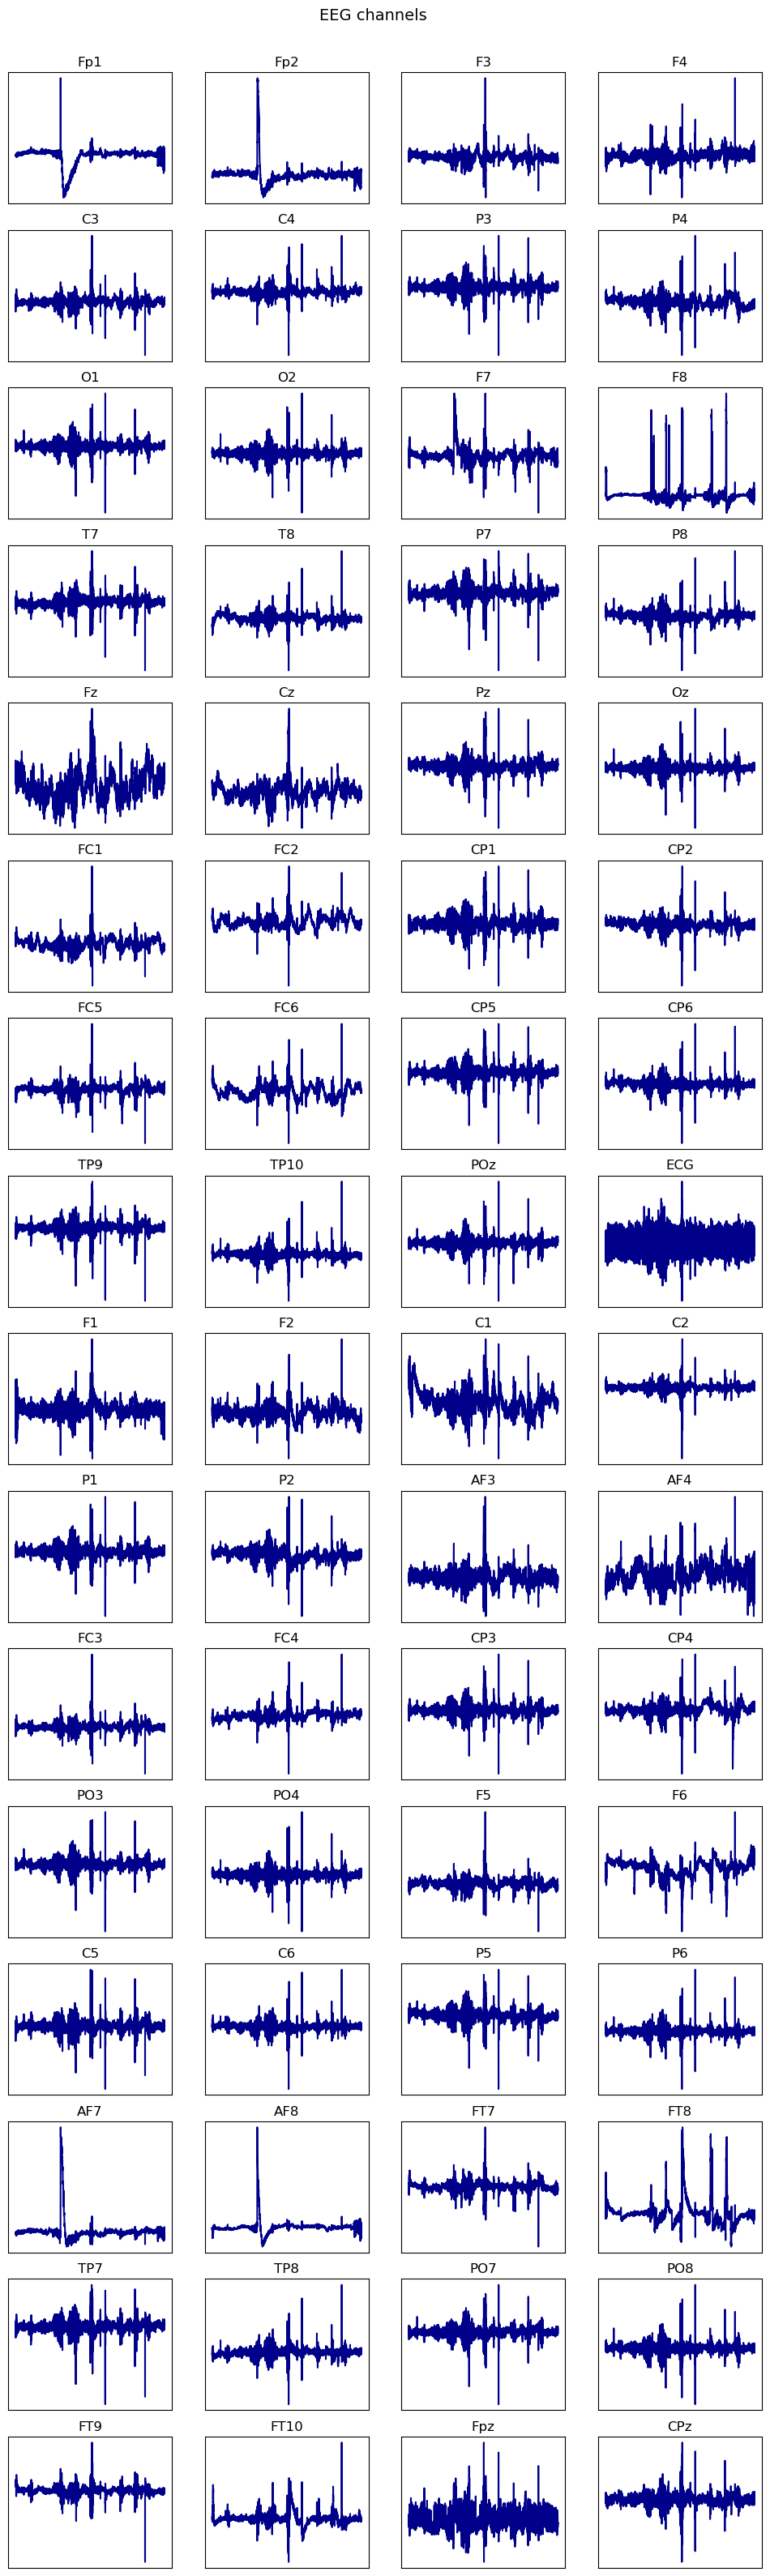

In [23]:
# Compare all channels. 
fig, axes = plt.subplots(nrows = 16, ncols = 4, figsize = (12, 40))
fig.suptitle('EEG channels', fontsize = 14, y = 0.9)
channel_index = 0

# Iterate through all channels. 
for channel in channels_data.ch_names:

    # Compute the row and column indexes. 
    row_index = channel_index // 4
    column_index = channel_index % 4
    
    # Plot the data for the channel. 
    axes[row_index, column_index].plot(np_channels_data[channel_index, :], c = 'darkblue')
    axes[row_index, column_index].set_title(channel)
    axes[row_index, column_index].tick_params(left = False, right = False, labelleft = False, 
                                              labelbottom = False, bottom = False) 

    # Increment. 
    channel_index += 1


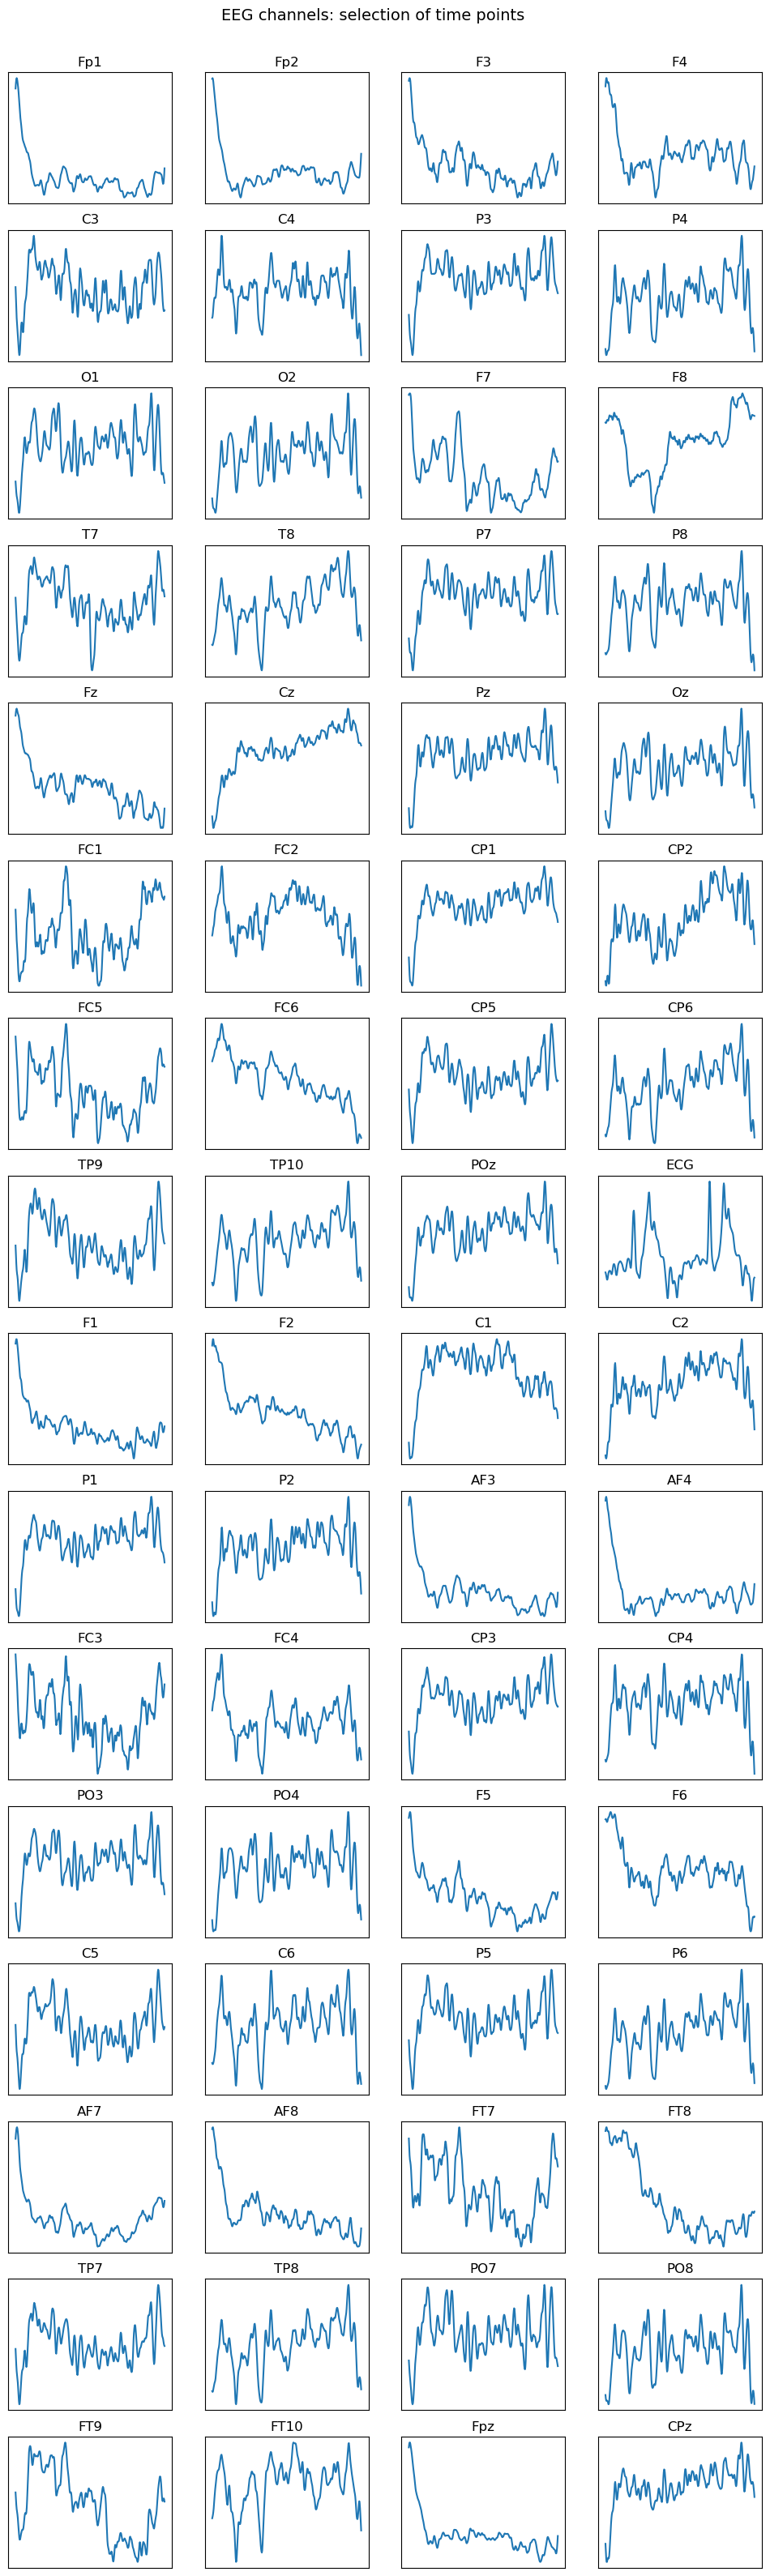

In [24]:
# Compare all channels, focusing on a selection of time points. 
fig, axes = plt.subplots(nrows = 16, ncols = 4, figsize = (12, 40))
fig.suptitle('EEG channels: selection of time points', fontsize = 14, y = 0.9)
channel_index = 0

# Iterate through all channels. 
for channel in channels_data.ch_names:

    # Compute the row and column indexes. 
    row_index = channel_index // 4
    column_index = channel_index % 4
    
    # Plot the data for the channel. 
    axes[row_index, column_index].plot(np_channels_data[channel_index, starting_point:ending_point])
    axes[row_index, column_index].set_title(channel)
    axes[row_index, column_index].tick_params(left = False, right = False, labelleft = False, 
                                              labelbottom = False, bottom = False) 

    # Increment. 
    channel_index += 1


In [25]:
# Compute the Power Spectral Density (PSD) for a selection of time points, for frequencies between 1 and 40 Hz, using the Welch method. 
psd_welch = channels_data.compute_psd(tmin = time_interval[0], tmax = time_interval[1], fmin = 1, fmax = 40, picks = 'eeg', method = 'welch')
psd_welch

Effective window size : 2.005 (s)


<Power Spectrum (from Raw, welch method) | 63 channels × 78 freqs, 1.5-39.9 Hz>

In [26]:
# Identify the new C1 channel index, since the ECG channel was dropped during the PSD computation. 
c1_channel_index_psd = psd_welch.ch_names.index('C1')
c1_channel_index_psd

33

In [27]:
# Extract the PSD data as a NumPy array, then store and display its shape. 
np_psd_welch = psd_welch.get_data()
nb_channels_psd = np_psd_welch.shape[0]
nb_bins_psd = np_psd_welch.shape[1]
np_psd_welch.shape

(63, 78)

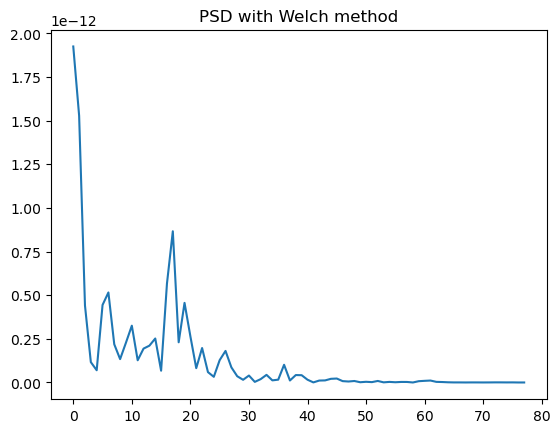

In [28]:
# Plot the PSD data for the C1 channel. 
plt.plot(np_psd_welch[c1_channel_index_psd, :])
plt.title('PSD with Welch method');

In [29]:
# Extract the PSD frequencies as a NumPy array, and display its shape. 
np_psd_welch_freqs = psd_welch.freqs
np_psd_welch_freqs.shape

(78,)

In [30]:
# Display the frequencies. 
np_psd_welch_freqs

array([ 1.49625935,  1.99501247,  2.49376559,  2.9925187 ,  3.49127182,
        3.99002494,  4.48877805,  4.98753117,  5.48628429,  5.98503741,
        6.48379052,  6.98254364,  7.48129676,  7.98004988,  8.47880299,
        8.97755611,  9.47630923,  9.97506234, 10.47381546, 10.97256858,
       11.4713217 , 11.97007481, 12.46882793, 12.96758105, 13.46633416,
       13.96508728, 14.4638404 , 14.96259352, 15.46134663, 15.96009975,
       16.45885287, 16.95760599, 17.4563591 , 17.95511222, 18.45386534,
       18.95261845, 19.45137157, 19.95012469, 20.44887781, 20.94763092,
       21.44638404, 21.94513716, 22.44389027, 22.94264339, 23.44139651,
       23.94014963, 24.43890274, 24.93765586, 25.43640898, 25.93516209,
       26.43391521, 26.93266833, 27.43142145, 27.93017456, 28.42892768,
       28.9276808 , 29.42643392, 29.92518703, 30.42394015, 30.92269327,
       31.42144638, 31.9201995 , 32.41895262, 32.91770574, 33.41645885,
       33.91521197, 34.41396509, 34.9127182 , 35.41147132, 35.91

In [31]:
# Compute the Power Spectral Density (PSD) for a selection of time points, for frequencies between 1 and 40 Hz, using the multitaper method. 
psd_multitaper = channels_data.compute_psd(tmin = time_interval[0], tmax = time_interval[1], fmin = 1, fmax = 40, picks = 'eeg', method = 'multitaper')
psd_multitaper

    Using multitaper spectrum estimation with 7 DPSS windows


<Power Spectrum (from Raw, multitaper method) | 63 channels × 78 freqs, 1.5-39.9 Hz>

In [32]:
# Extract the PSD data as a NumPy array, and display its shape. 
np_psd_multitaper = psd_multitaper.get_data()
np_psd_multitaper.shape

(63, 78)

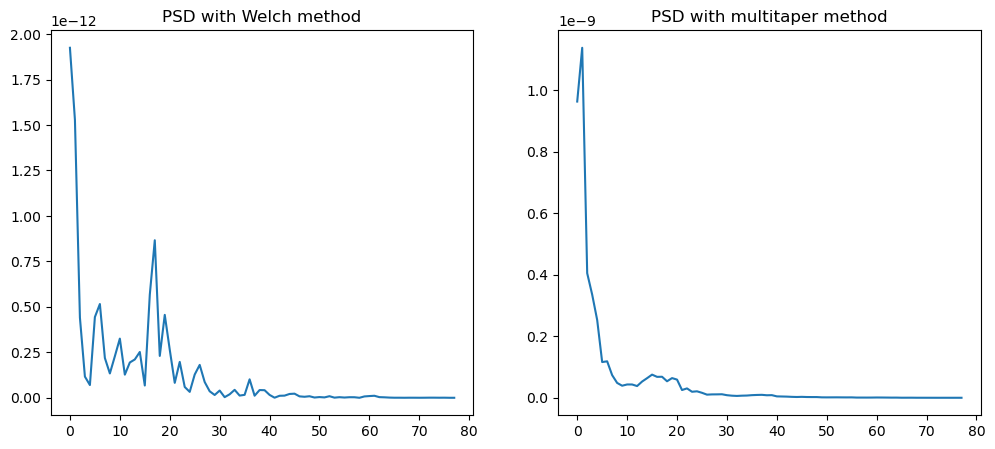

In [33]:
# Plot the PSD data for the C1 channel, comparing the Welch method and the multitaper method. 
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes[0].plot(np_psd_welch[c1_channel_index_psd, :])
axes[0].set_title('PSD with Welch method')
axes[1].plot(np_psd_multitaper[c1_channel_index_psd, :])
axes[1].set_title('PSD with multitaper method');

In [34]:
# Define the frequency bands of interest. 
frequency_bands = [(1, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'), (12, 16, 'Sigma'), (16, 30, 'Beta'), (30, 40, 'Gamma')]
frequency_bands

[(1, 4, 'Delta'),
 (4, 8, 'Theta'),
 (8, 12, 'Alpha'),
 (12, 16, 'Sigma'),
 (16, 30, 'Beta'),
 (30, 40, 'Gamma')]

In [35]:
# Using the YASA library, compute the bandpowers for a selection of time points, for our frequency bands of interest, using the Welch method. 
bandpowers = yasa.bandpower(np_channels_data[:, starting_point:ending_point], 
                            sf = sampling_frequency, ch_names = channels_data.ch_names, 
                            bands = frequency_bands, win_sec = 2)
bandpowers

Delta     Theta     Alpha     Sigma      Beta     Gamma  \
Chan                                                               
Fp1   0.572535  0.336340  0.033168  0.028720  0.027503  0.001735   
Fp2   0.647370  0.179711  0.106139  0.030980  0.032926  0.002875   
F3    0.385527  0.443982  0.084922  0.027196  0.053737  0.004636   
F4    0.517289  0.365549  0.056774  0.026366  0.031795  0.002226   
C3    0.171435  0.386040  0.218911  0.133508  0.087678  0.002428   
...        ...       ...       ...       ...       ...       ...   
PO8   0.290636  0.367236  0.189356  0.130412  0.021546  0.000814   
FT9   0.516539  0.416764  0.026549  0.023586  0.015717  0.000844   
FT10  0.590978  0.335753  0.043581  0.014255  0.014848  0.000585   
Fpz   0.631579  0.204415  0.092298  0.037839  0.031436  0.002434   
CPz   0.304836  0.229145  0.272712  0.115114  0.074499  0.003694   

       TotalAbsPow  FreqRes  Relative  
Chan                                   
Fp1   6.852587e-11      0.5      True  
Fp2   5.440653e-11      0.5      True  
F3    1.287512e-11      0.5      True  
F4    1.371988e-11      0.5      True  
C3    1.133895e-11      0.5      True  
...            ...      ...       ...  
PO8   1.267450e-10      0.5      True  
FT9   1.377688e-10      0.5      True  
FT10  1.886207e-10      0.5      True  
Fpz   4.841667e-11      0.5      True  
CPz   6.809918e-12      0.5      True  

[64 rows x 9 columns]

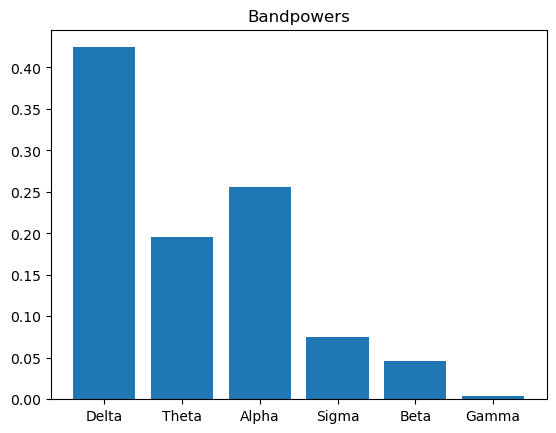

In [36]:
# Plot the bandpowers. 
frequency_bands_names = ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']
plt.bar(frequency_bands_names, bandpowers.iloc[c1_channel_index, 0:6])
plt.title('Bandpowers');

## **3. Features Extraction**

- **Features**: We define the number of scans of interest, and compute the PSD and the bandpowers for each of these scans. We extract the features values for each subject, focusing on our three conditions of interest: eegNF, fmriNF, eegfmriNF. We choose a scan duration of 2 seconds, the same than for the fMRI data. We notice that the eegNF condition is missing for subject sub-xp102, and that the fmriNF and eegfmriNF conditions are slightly longer for subject sub-xp104. 

In [37]:
# Define the number of scans, the scan duration in seconds, and the minimal and maximal frequencies for the PSD. 
nb_scans = 200
scan_duration = 2 # In seconds. 
fmin = 1 # In Hz. 
fmax = 40 # In Hz. 

# Define the features dictionaries and the summary DataFrame. 
dict_features_welch_psd_values = dict()
dict_features_multitaper_psd_values = dict()
dict_features_bandpowers_values = dict()
df_summary = pd.DataFrame()

# Compute and display the sampling window, i.e., the number of data points during each scan duration. 
sampling_window = int(scan_duration * sampling_frequency)
sampling_window

400

In [38]:
%%capture
# The magic command above hides all outputs from this cell. 

# Iterate through all subjects. 
for subject in subjects:

    # Display current subject. 
    print(subject)

    # Define the subject dictionaries. 
    dict_features_welch_psd_values[subject] = dict()
    dict_features_multitaper_psd_values[subject] = dict()
    dict_features_bandpowers_values[subject] = dict()

    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            df_summary.loc[subject, condition] = 'Missing'
            continue

        # Load and extract the EEG data. 
        vhdr_path = raw_data_path + 'derivatives/' + subject + '/eeg_pp/' + subject + '_task-' + condition + '_eeg_pp.vhdr'
        channels_data = mne.io.read_raw_brainvision(vhdr_path, misc = ['ECG'], preload = True, verbose = False)
        np_channels_data = channels_data.get_data()
        df_summary.loc[subject, condition] = str(np_channels_data.shape)

        # Define the condition dictionaries, and the arrays to store the PSD and bandpowers values. 
        dict_features_welch_psd_values[subject][condition] = np.zeros((nb_channels_psd, nb_bins_psd, nb_scans))
        dict_features_multitaper_psd_values[subject][condition] = np.zeros((nb_channels_psd, nb_bins_psd, nb_scans))
        dict_features_bandpowers_values[subject][condition] = np.zeros((nb_channels_psd, len(frequency_bands), nb_scans))
        
        # Iterate through all scans. 
        for scan in range(nb_scans):

            # Compute and extract the PSD using Welch and multitaper methods. 
            np_psd_welch = channels_data.compute_psd(tmin = (scan * scan_duration), tmax = (scan * scan_duration) + scan_duration, 
                                                     fmin = fmin, fmax = fmax, picks = 'eeg', method = 'welch').get_data()
            np_psd_multitaper = channels_data.compute_psd(tmin = (scan * scan_duration), tmax = (scan * scan_duration) + scan_duration, 
                                                          fmin = fmin, fmax = fmax, picks = 'eeg', method = 'multitaper').get_data()
            
            # Compute the bandpowers using Welch method. 
            bandpowers = yasa.bandpower(np_channels_data[:, (scan * sampling_window):(scan * sampling_window) + sampling_window], 
                                        sf = sampling_frequency, ch_names = channels_data.ch_names, 
                                        bands = frequency_bands, win_sec = scan_duration)
                    
            # Store the PSD and bandpowers values. 
            dict_features_welch_psd_values[subject][condition][:, :, scan] = np_psd_welch
            dict_features_multitaper_psd_values[subject][condition][:, :, scan] = np_psd_multitaper
            dict_features_bandpowers_values[subject][condition][:, :, scan] = bandpowers.iloc[:, 0:6].drop('ECG')

In [39]:
# Display the summary DataFrame. 
df_summary

eegNF       fmriNF    eegfmriNF
sub-xp101  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp102      Missing  (64, 80200)  (64, 80200)
sub-xp103  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp104  (64, 80200)  (64, 80400)  (64, 80400)
sub-xp105  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp106  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp107  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp108  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp109  (64, 80200)  (64, 80200)  (64, 80200)
sub-xp110  (64, 80200)  (64, 80200)  (64, 80200)

## **4. Feature Engineering**

- **Normalization**: We explore the systematic biases in our EEG data, and normalize our features. We notice that the different bandpowers have significantly different mean values, a common observation in EEG datasets. Therefore, we normalize the bandpowers features, and replace the outliers (STD > 4) by the values of the previous scan, while also keeping the bandpowers without normalization as an alternative features set. 

- **Next steps**: We store all the relevant values in dictionaries, and save them in the preprocessing directory. Overall, we will have four alternative features sets for the machine learning and deep learning steps: the PSD using the Welch method, the PSD using the multitaper method, the bandpowers, and the normalized bandpowers. 

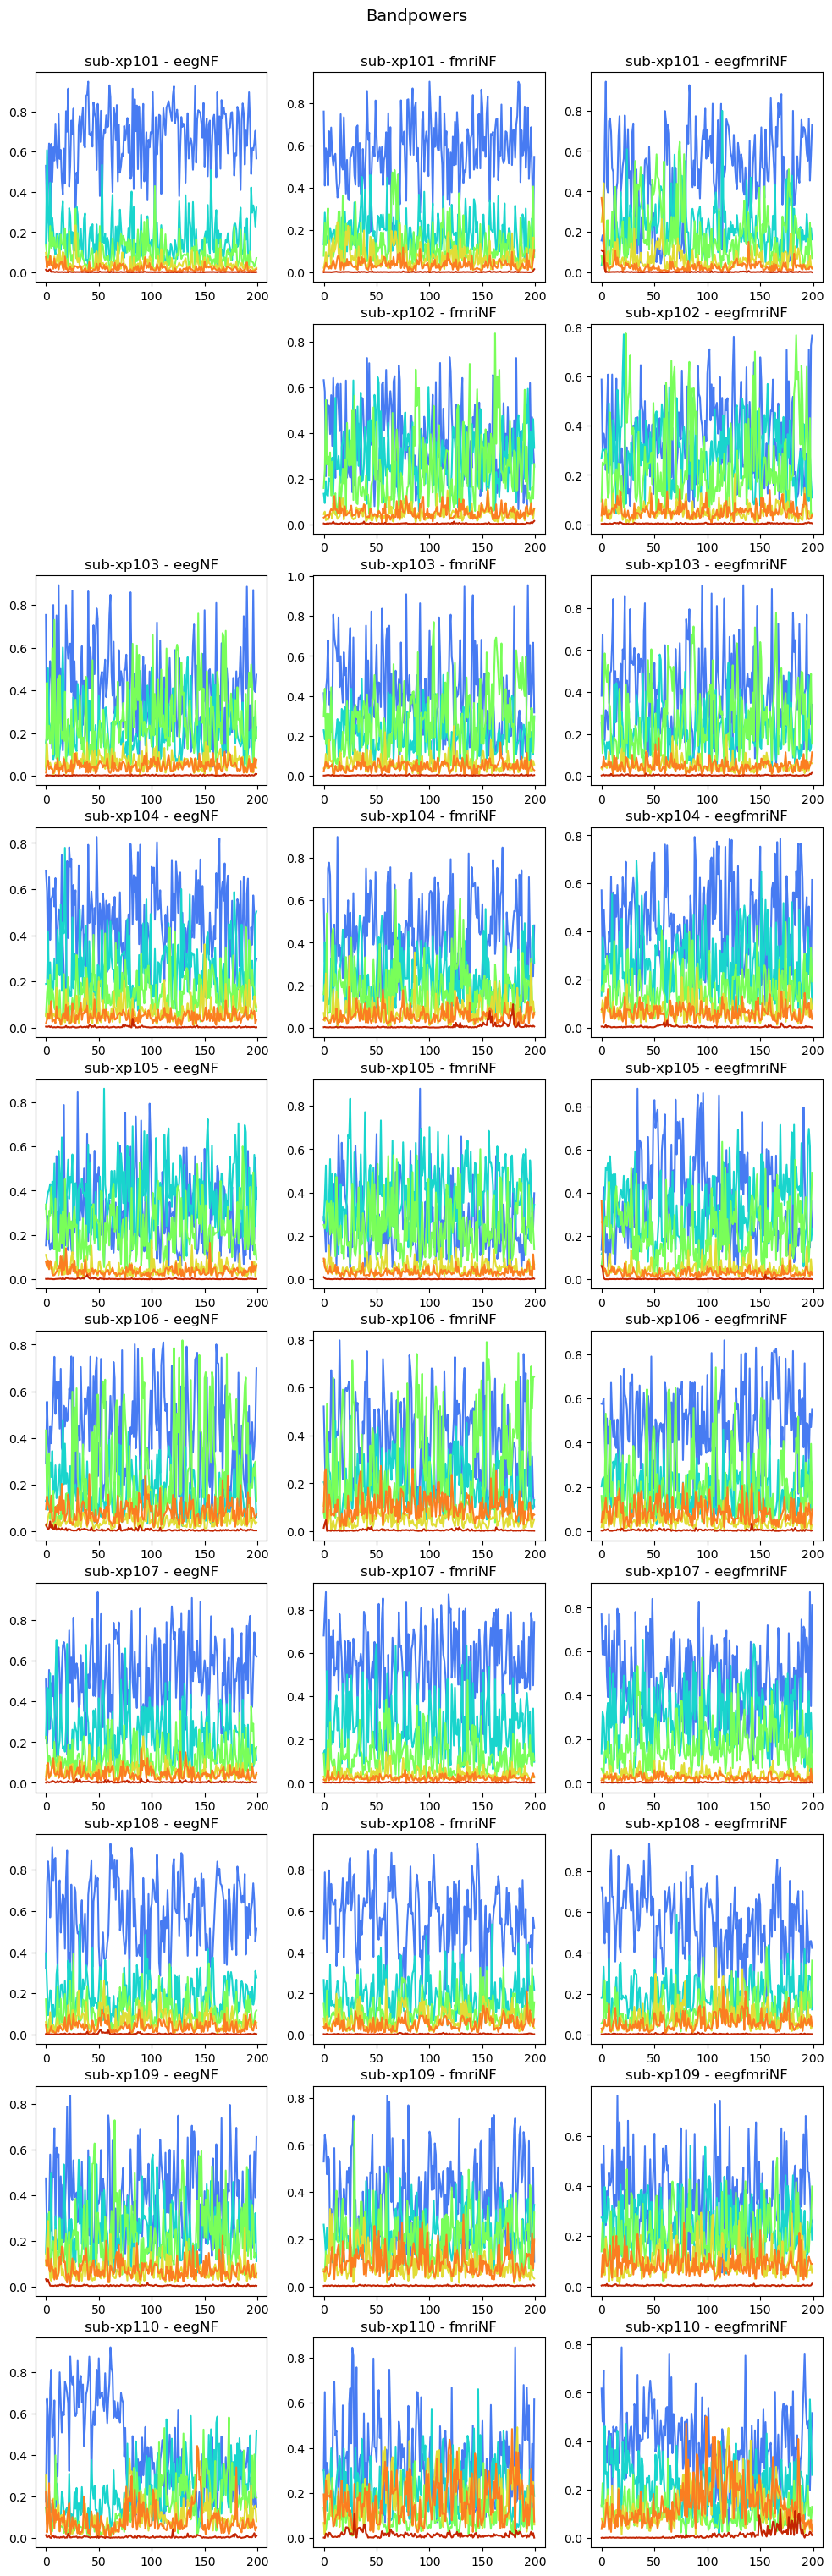

In [40]:
# Plot the bandpowers values by subject and condition for the C1 channel. 
fig, axes = plt.subplots(nrows = 10, ncols = 3, figsize = (12, 38))
fig.suptitle('Bandpowers', fontsize = 14, y = 0.9)
subject_index = 0

# Iterate through all subjects. 
for subject in subjects:
    condition_index = 0
    
    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:
        bandpower_index = 0

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            axes[subject_index, condition_index].set_visible(False)
            condition_index += 1
            continue

        # Iterate through all bandpowers. 
        for bandpower in ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']:
            
            # Define colormap and select a color. 
            cm = plt.colormaps['turbo']
            c = cm(0.15 * bandpower_index + 0.15)
    
            # Retrieve and plot the bandpowers values for the C1 channel. The C1 channel position is shifted because we dropped the ECG channel. 
            bandpower_values = dict_features_bandpowers_values[subject][condition][c1_channel_index_psd, bandpower_index, :]
            axes[subject_index, condition_index].plot(bandpower_values, color = c)
            axes[subject_index, condition_index].set_title(subject + ' - ' + condition)

            # Increment the bandpower index. 
            bandpower_index += 1

        # Increment the condition index. 
        condition_index += 1

    # Increment the subject index. 
    subject_index += 1

In [41]:
# Define a dictionary to store the normalized bandpowers, and a DataFrame to store the outliers. 
dict_features_bandpowers_normalized = dict()
df_outliers = pd.DataFrame()

# Iterate through all subjects. 
for subject in subjects:

    # Define the subject dictionary. 
    dict_features_bandpowers_normalized[subject] = dict()
    
    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            continue

        # Compute the normalized bandpowers. 
        bandpowers = dict_features_bandpowers_values[subject][condition]
        bandpowers_mean = np.mean(bandpowers, axis = 2)
        bandpowers_std = np.std(bandpowers, axis = 2)
        bandpowers_normalized = (bandpowers - bandpowers_mean[:, :, np.newaxis]) / bandpowers_std[:, :, np.newaxis]

        # Iterate through all bandpowers. 
        for bandpower_index in range(dict_features_bandpowers_values[subject][condition].shape[1]):
             
             # Iterate through all channels. 
            for channel_index in range(dict_features_bandpowers_values[subject][condition].shape[0]):

                # Replace the outliers (STD > 4) by the value of the previous scan. 
                outliers_counter = 0
                for scan in range(nb_scans):
                    if np.abs(bandpowers_normalized[channel_index, bandpower_index, scan]) > 4:
                        bandpowers_normalized[channel_index, bandpower_index, scan] = bandpowers_normalized[channel_index, bandpower_index, scan - 1]
                        outliers_counter += 1
                    
            # Store the number of outliers in the DataFrame. 
            df_outliers.loc[subject + '/' + condition, 'subject'] = subject
            df_outliers.loc[subject + '/' + condition, 'condition'] = condition
            df_outliers.loc[subject + '/' + condition, frequency_bands_names[bandpower_index]] = outliers_counter

        # Store the normalized bandpowers. 
        dict_features_bandpowers_normalized[subject][condition] = bandpowers_normalized

# Change the indexes and the data type of the outliers DataFrame. 
df_outliers = df_outliers.set_index(['subject', 'condition'])
df_outliers = df_outliers.astype(int)

In [42]:
# Display the outliers DataFrame. 
df_outliers

Delta  Theta  Alpha  Sigma  Beta  Gamma
subject   condition                                         
sub-xp101 eegNF          0      1      0      2     2      4
          fmriNF         0      0      0      1     0      2
          eegfmriNF      0      0      0      2     3      3
sub-xp102 fmriNF         0      0      0      0     0      2
          eegfmriNF      0      0      0      0     1      1
sub-xp103 eegNF          0      0      0      0     1      1
          fmriNF         0      0      0      0     1      0
          eegfmriNF      0      0      0      2     1      1
sub-xp104 eegNF          0      1      1      0     1      1
          fmriNF         0      0      0      1     1      2
          eegfmriNF      0      0      1      0     0      4
sub-xp105 eegNF          1      0      0      1     3      3
          fmriNF         0      0      0      1     1      1
          eegfmriNF      0      0      0      1     1      2
sub-xp106 eegNF          0      0      0      0     0      3
          fmriNF         0      0      0      1     0      2
          eegfmriNF      0      0      0      1     0      2
sub-xp107 eegNF          0      0      1      0     1      1
          fmriNF         0      0      0      2     1      1
          eegfmriNF      0      0      1      2     0      2
sub-xp108 eegNF          0      0      0      0     1      3
          fmriNF         0      0      0      1     2      0
          eegfmriNF      0      0      0      1     0      2
sub-xp109 eegNF          0      0      0      0     2      2
          fmriNF         0      0      1      1     2      0
          eegfmriNF      0      0      0      1     2      2
sub-xp110 eegNF          0      0      0      0     2      1
          fmriNF         0      0      0      1     0      0
          eegfmriNF      0      1      0      0     1      1

In [43]:
# Display the number of outliers by frequency band. 
print(df_outliers.sum())

Delta     1
Theta     3
Alpha     5
Sigma    22
Beta     30
Gamma    49
dtype: int64


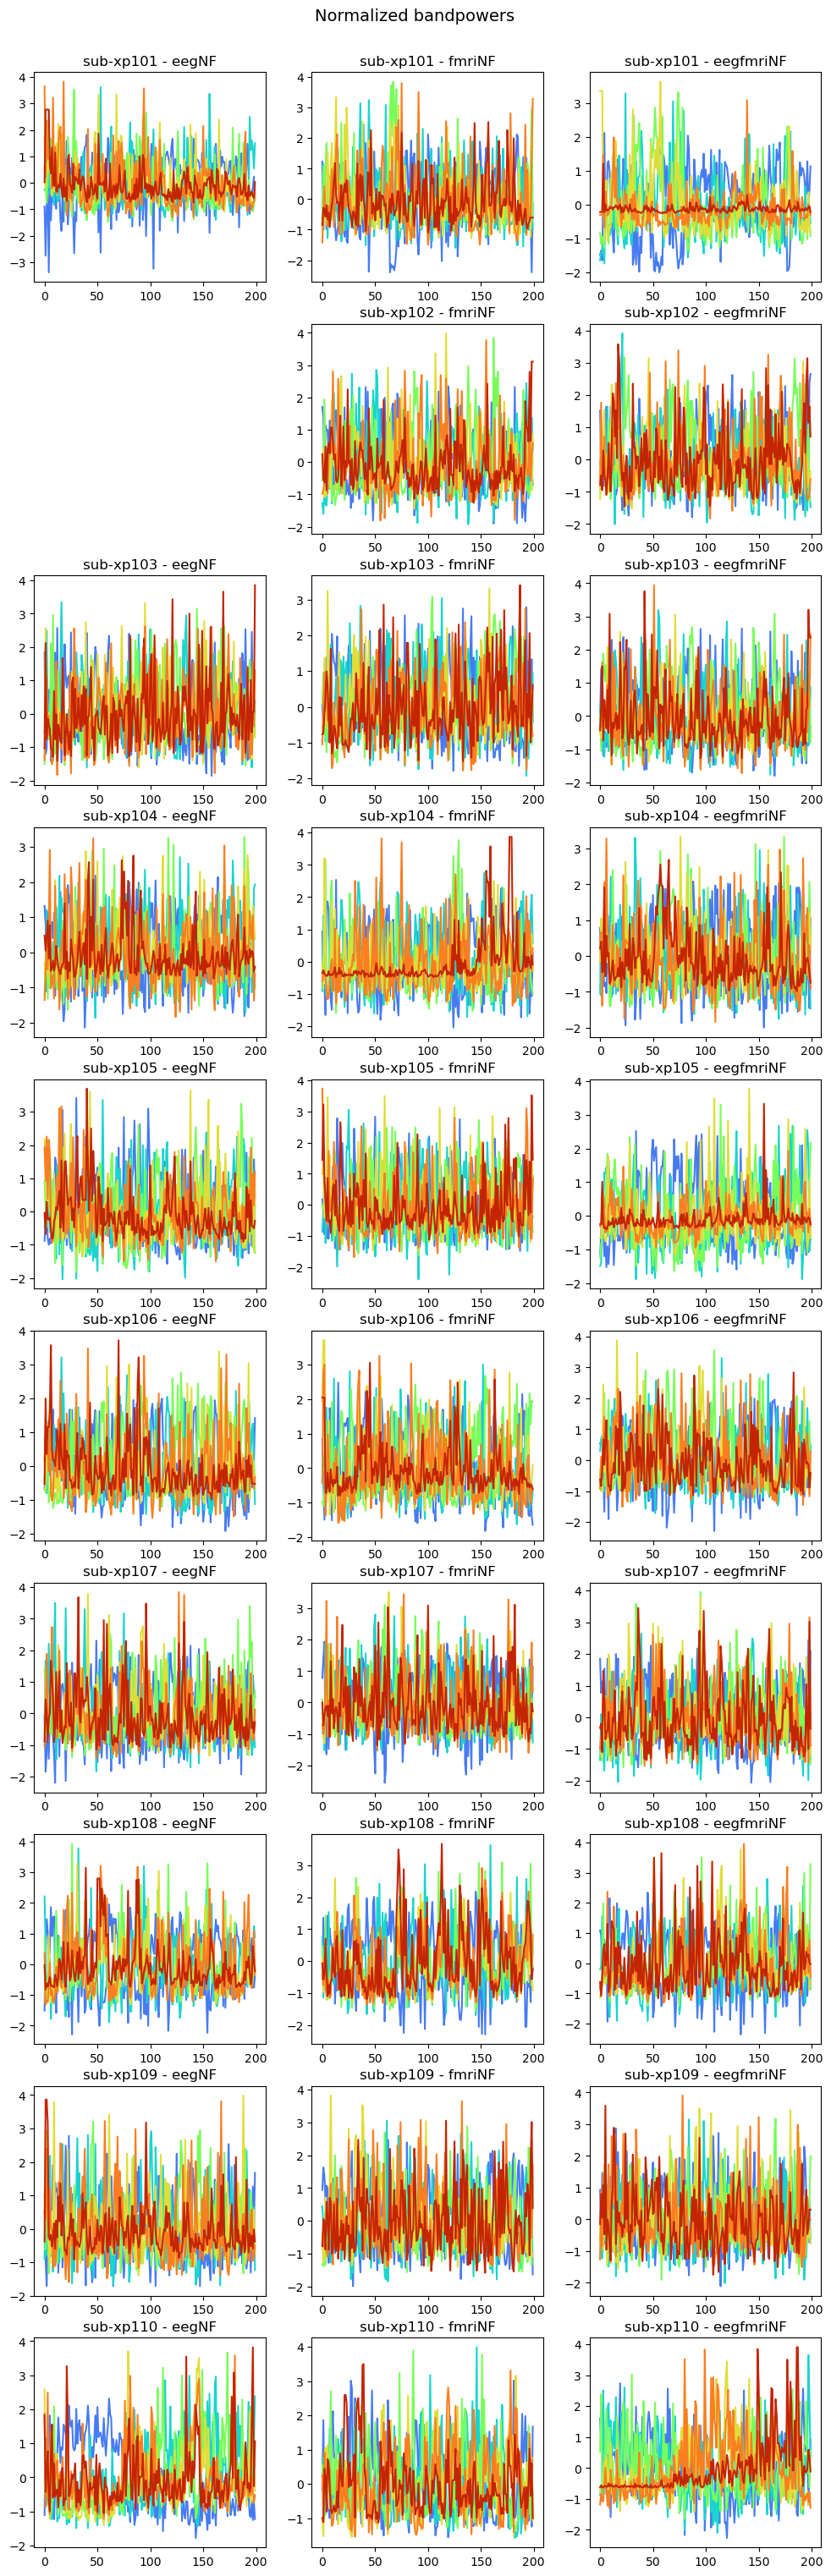

In [44]:
# Plot the normalized bandpowers values by subject and condition for the C1 channel. 
fig, axes = plt.subplots(nrows = 10, ncols = 3, figsize = (12, 38))
fig.suptitle('Normalized bandpowers', fontsize = 14, y = 0.9)
subject_index = 0

# Iterate through all subjects. 
for subject in subjects:
    condition_index = 0
    
    # Iterate through all conditions. 
    for condition in ['eegNF', 'fmriNF', 'eegfmriNF']:
        bandpower_index = 0

        # Skip the current iteration for sub-xp102 and eegNF, since that run is missing. 
        if subject == 'sub-xp102' and condition == 'eegNF':
            axes[subject_index, condition_index].set_visible(False)
            condition_index += 1
            continue

        # Iterate through all bandpowers. 
        for bandpower in ['Delta', 'Theta', 'Alpha', 'Sigma', 'Beta', 'Gamma']:
            
            # Define colormap and select a color. 
            cm = plt.colormaps['turbo']
            c = cm(0.15 * bandpower_index + 0.15)
    
            # Retrieve and plot the normalized bandpowers values for the C1 channel. The C1 channel position is shifted because we dropped the ECG channel. 
            bandpower_values = dict_features_bandpowers_normalized[subject][condition][c1_channel_index_psd, bandpower_index, :]
            axes[subject_index, condition_index].plot(bandpower_values, color = c)
            axes[subject_index, condition_index].set_title(subject + ' - ' + condition)

            # Increment the bandpower index. 
            bandpower_index += 1

        # Increment the condition index. 
        condition_index += 1

    # Increment the subject index. 
    subject_index += 1

In [45]:
# Save the features into Pickle files. 
with open(preprocessed_data_path + 'features/dict_features_welch_psd.p', 'wb') as file:
    pickle.dump(dict_features_welch_psd_values, file)
with open(preprocessed_data_path + 'features/dict_features_multitaper_psd.p', 'wb') as file:
    pickle.dump(dict_features_multitaper_psd_values, file)
with open(preprocessed_data_path + 'features/dict_features_bandpowers.p', 'wb') as file:
    pickle.dump(dict_features_bandpowers_values, file)
with open(preprocessed_data_path + 'features/dict_features_bandpowers_normalized.p', 'wb') as file:
    pickle.dump(dict_features_bandpowers_normalized, file)